In [0]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
 
from scipy.stats import norm
from sklearn import manifold

%matplotlib inline
import seaborn as sns
plt.style.use("seaborn")

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )


Torch 1.0.1.post2 CUDA 9.0.176
Device: cuda:0
True


In [0]:
## Data loader
def get_dataloaders(path, batch_size, pad = False):
    path = os.path.join(path,"MNIST/data")
    print(path)
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root = path, 
                    train = True, download = False, 
                    transform = transform)
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                     batch_size = batch_size, 
                            shuffle = True)
    
    test_dataset = datasets.MNIST(root=path,train=False,
                                  transform=transform,download=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                         batch_size=batch_size,shuffle=True)
    
    
    return (train_loader, test_loader)

In [0]:

"""
Load model
"""
def load_model(model, filepath):
    state = torch.load(filepath)
    model.load_state_dict(state['model'])
    model.cuda()
    
    
def load_model_state(model, filepath):
    state = torch.load(filepath)
    model.load_state_dict(state)
    model.cuda()

In [0]:
          
"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, file):
  model.eval()
  datapoint = datapoint.to(device)
  if isinstance(model,ConvVAE):
    datapoint = datapoint.unsqueeze(0)
    mu, _ = model.encode(datapoint)
  else:
    datapoint = datapoint.unsqueeze(0)
    mu, _ = model.encoder(datapoint)
  
  recons = torch.zeros((7, nb_latents, 28, 28))
    
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      muc[zi] = val  
      recon = model.decode(muc).cpu() 
        if isinstance(model,ConvVAE) else model.decoder(muc).cpu()
      recons[i, zi] = recon.view(28, 28)

  torchvision.utils.save_image(recons.view(-1, 1, 28, 28), 
                               file, nrow=nb_latents, pad_value=1)
  

import cv2
import numpy


def laplacian_variance(images):
    return [cv2.Laplacian(image.numpy(), cv2.CV_32F).var() for image in images]


def laplacian_variance_numpy(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]


In [0]:
class ConvVAE(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAE, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 
                      kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, 
                        kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 
                         kernel_size=2, stride=2)
    
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
vae_model = ConvVAE(10)
if is_cuda:
    vae_model = vae_model.to(device)
    
## load model
checkpoint_dir = './vae-final/checkpoints'
filename = checkpoint_dir +"/model_state_ "+str(99)+ ".pth"
load_model(vae_model, filename)

In [0]:
class Params:
  nb_latents = 10
  batch_size = 128
  epochs = 100
  log_interval = 100
  save_interval = 1000
  data_dir =  "./vae-classifier/"
train_loader, test_loader = get_dataloaders(Params.data_dir, Params.batch_size)

./vae-classifier/MNIST/data


In [0]:
## TSNE for VAE
## Test TSNE plot for reconstrunction on 1000 test samples

transformation = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(os.path.join(Params.data_dir,"MNIST/data"),
              train=True,transform=transformation,download=False)
testing_tsne = torch.utils.data.DataLoader(train_dataset,
                 batch_size=len(train_dataset),shuffle=True)
test_data, test_labels = next(iter(testing_tsne))[:10000]


Computing latent space projection...


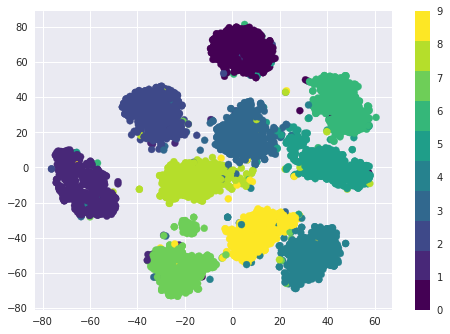

In [0]:
path = "./vae-final/samples/"+'/latent_space.png'
def visualize_tsne(X, labels, model, path):
    # Compute latent space representation
    print("Computing latent space projection...")
    
    #if isinstance(model,VAE_GAN_Generator):
     #   X_encoded, _ = model.encoder(X)
    #else:
    X_encoded, _ = model.encode(X)
    
    # Compute t-SNE embedding of latent space
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.data.detach().cpu())

    # Plot images according to t-sne embedding
    fig, ax = plt.subplots()
    plt.scatter(X_tsne[:,0], X_tsne[:,1],
                c=labels, cmap=plt.cm.get_cmap("viridis", 10))
    plt.colorbar(ticks=range(10))
    fig.savefig(path, dpi=fig.dpi)
    
visualize_tsne(test_data[:5000].to(device),test_labels[:5000],vae_model,path)


## Beta VAE


In [0]:
beta_vae = ConvVAE(Params.nb_latents)
if is_cuda:
    beta_vae = beta_vae.to(device)
    

## load model
#model_state_99.pth
checkpoint_dir = 'beta-results'
filename = checkpoint_dir +"/model_state_"+str(99)+ ".pth"
load_model_state(beta_vae, filename)

Computing latent space projection...


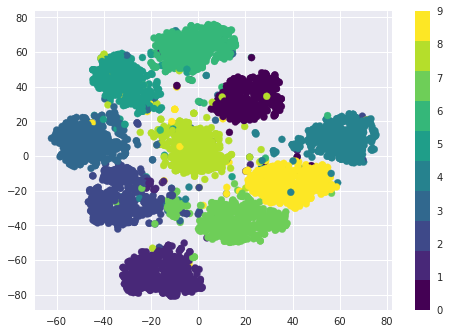

In [0]:
path = "beta-results/latent-space.png"
visualize_tsne(test_data[:5000].to(device),
               test_labels[:5000],beta_vae,path)


## VAE+GAN

In [0]:
## Load GAN Model
def load_Vae_gan(epoch, encoder, decoder, D):
    save_dir = "vae-gan"
    #  restore models
    decoder.load_state_dict(torch.load(save_dir+
          '/VAE_GAN_decoder_%d.pth' % epoch))
    decoder.cuda()
    encoder.load_state_dict(torch.load(save_dir +
     '/VAE_GAN_encoder_%d.pth' % epoch))
    encoder.cuda()
    D.load_state_dict(torch.load(save_dir+
      '/VAE_GAN_D_%d.pth' % epoch))
    D.cuda()

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_channels, output_channels, representation_size = 32):
        super(Encoder, self).__init__()
        # input parameters
        self.input_channels = input_channels
        self.output_channels = output_channels #Params.nb_latents
        
        self.features = nn.Sequential(
            # nc x 32 x 32
            nn.Conv2d(self.input_channels, 
                      representation_size, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size),
            nn.ReLU(),
            # hidden_size x 16 x 16
            nn.Conv2d(representation_size, 
                      representation_size*2, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 2),
            nn.ReLU(),
            # hidden_size*2 x 8 x 8
            nn.Conv2d(representation_size*2, 
                      representation_size*4, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 4),
            nn.ReLU())
            # hidden_size*4 x 4 x 4
            
        self.mean = nn.Sequential(
            nn.Linear(representation_size*4*4*4, 1024),
             
            nn.ReLU(),
            nn.Linear(1024, output_channels))
        
        self.logvar = nn.Sequential(
            nn.Linear(representation_size*4*4*4, 1024),
          
            nn.ReLU(),
            nn.Linear(1024, output_channels))
        
    def forward(self, x):
        batch_size = x.size()[0]

        hidden_representation = self.features(x)
        hidden_representation = hidden_representation
        .view(-1, self.num_flat_features(hidden_representation))
        
        mean = self.mean(hidden_representation)
        logvar = self.logvar(hidden_representation)

        return mean, logvar
    
    def hidden_layer(self, x):
        batch_size = x.size()[0]
        output = self.features(x)
        return output
      
      
    def num_flat_features(self,x):
      size = x.size()[1:] # all dimensions except the batch dimension
      num_features = 1
      for s in size:
        num_features *=s
      return num_features

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        
        self.input_size = input_size ##
        
        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        
        # 1 x 28 x 28
        self.activation = nn.Sigmoid()
        self.relu = nn.Tanh()
            
    
    def forward(self, z):
        bs = z.size()[0]
        
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
       
        return self.activation(x)

In [0]:
class VAE_GAN_Generator(nn.Module):
    def __init__(self, input_channels, hidden_size):
        super(VAE_GAN_Generator, self).__init__()
        self.input_channels = input_channels
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(input_channels, hidden_size)
        self.decoder = Decoder(hidden_size)
        
    def forward(self, x):
        batch_size = x.size()[0]
        mean, logvar = self.encoder(x)
        std = logvar.mul(0.5).exp_()
        
        reparametrized_noise = Variable(torch.randn(
            (batch_size, self.hidden_size))).cuda()

        reparametrized_noise = mean + std * reparametrized_noise

        rec_images = self.decoder(reparametrized_noise)
        
        return mean, logvar, rec_images

In [0]:
class Discriminator(nn.Module):
    def __init__(self,input_channels, representation_size = 32):
        super(Discriminator, self).__init__()
        self.input_channels = input_channels
        dim = 128 * 4 * 4
        self.main = nn.Sequential(
            # nc x 32 x 32
            nn.Conv2d(self.input_channels, 
               representation_size, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size),
            nn.LeakyReLU(0.2),
            # hidden_size x 16 x 16
            nn.Conv2d(representation_size, 
             representation_size*2, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 2),
            nn.LeakyReLU(0.2),
            # hidden_size*2 x 8 x 8
            nn.Conv2d(representation_size*2, 
              representation_size*4, 5, stride=2, padding=2),
            nn.BatchNorm2d(representation_size * 4),
            nn.LeakyReLU(0.2))

        self.lth_features = nn.Sequential(
            nn.Linear(dim, 2048),
            nn.LeakyReLU(0.2))
            
        self.sigmoid_output = 
        nn.Sequential(nn.Linear(2048,1),nn.Sigmoid())


    def forward(self, x):
        batch_size = x.size()[0]
        features = self.main(x)
        lth_rep = self.
        lth_features(features.view(batch_size, -1))
        output = self.sigmoid_output(lth_rep)
        return output
    
    def similarity(self, x):
        batch_size = x.size()[0]
        features = self.main(x)
        lth_rep = self.
        lth_features(features.view(batch_size, -1))
        return lth_rep

In [0]:
# define constant
input_channels = 1
hidden_size = 10
max_epochs = 250
lr = 3e-4

beta = 5
alpha = 0.1
gamma = 15

In [0]:
G = VAE_GAN_Generator(input_channels, hidden_size).cuda()
D = Discriminator(input_channels).cuda()

criterion = nn.BCELoss()
criterion.cuda()

opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)

In [0]:
load_Vae_gan(210, G.encoder, G.decoder, D)


In [ ]:
path = "vae-gan/latent-space.png"
visualize_tsne(test_data[:5000].to(device),test_labels[:5000],G,path)


## PLOTS

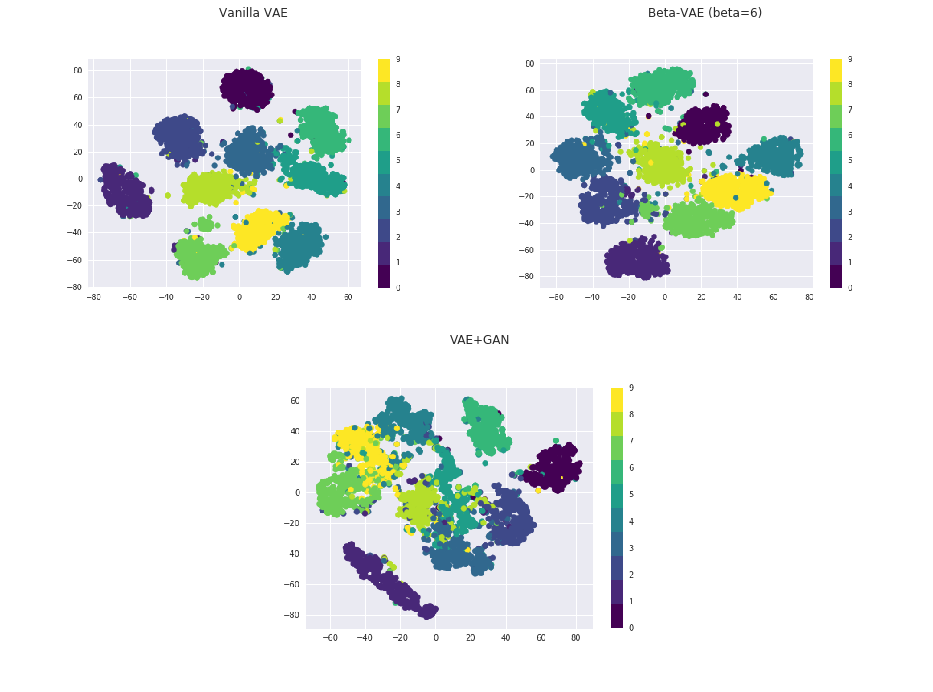

In [0]:
## TSNE Plot of VAE, Beta VAE and VAE + GAN
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

rows  = 2
columns = 3

fig_height = 5.
length_x_axis = 100
length_y_axis = 45
height = length_y_axis * rows
width = length_x_axis  * columns

plot_aspect_ratio=2

fig = plt.figure(figsize = (16,12))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0.025, hspace=0.05)

## Train 
ax1 = plt.subplot(gs[0, 0])
vae_tsne = "vae-final/samples" + '/latent_space.png'
img=mpimg.imread(vae_tsne)
imgplot = plt.imshow(img)
plt.axis("off")
plt.title("Vanilla VAE")

ax2 = plt.subplot(gs[0, 1])
betavae_tsne = "beta-results/latent-space.png"
img=mpimg.imread(betavae_tsne)
imgplot = plt.imshow(img)
plt.axis("off")
plt.title("Beta-VAE (beta=6)")

ax3 = plt.subplot(gs[1,0:])
vae_gan_tsne = "./vae-gan/latent-space.png"
img=mpimg.imread(vae_gan_tsne)
imgplot = plt.imshow(img)
plt.title("VAE+GAN")
plt.axis("off")
plt.savefig("vae-final/tsne-results.png")

## Reconstructions

In [0]:
def reconstruction(model, data,path):
    n = min(data.size(0), 10)
    recon_batch, mu, logvar = model(data)
    comparison = torch.cat([data[:n],recon_batch[:n]])
    save_image(comparison.cpu(),path, nrow=Params.nb_latents, pad_value=1)

    
train_batch, train_label = next(iter(train_loader))
test_batch, test_label = next(iter(test_loader))

In [0]:
filename = os.path.join("vae-final/", 'vae_reconstruction.png')
reconstruction(vae_model,train_batch.to(device),filename)


In [0]:
filename = os.path.join("vae-final/", 'beta_vae_reconstruction.png')
reconstruction(beta_vae,train_batch.to(device),filename)

In [0]:
def reconstruction_vae_gan(model, data,path):
    n = min(data.size(0), 10)
    _, _, rec_imgs = model(data)
    comparison = torch.cat([data[:n],rec_imgs[:n]])
    save_image(comparison.cpu(),path, 
               nrow=Params.nb_latents, pad_value=1)
    
filename = os.path.join("vae-final/", 
          'vae_gan_reconstruction.png')
reconstruction_vae_gan(G,train_batch.to(device),filename)

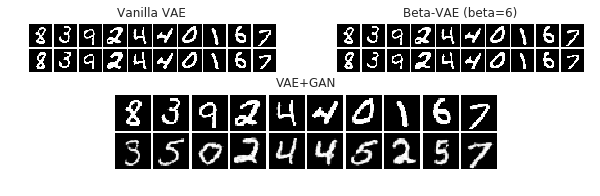

In [0]:
rows  = 2
columns = 3

fig_height = 5.
length_x_axis = 100
length_y_axis = 45
height = length_y_axis * rows
width = length_x_axis  * columns

plot_aspect_ratio= float(width)/float(height)

fig = plt.figure(figsize=(10,3))

gs = gridspec.GridSpec(2,2)
gs.update(wspace = 0.23, hspace = 0.05)
## Train 
ax1 = plt.subplot(gs[0, 0])
vae_tsne = "vae-final/vae_reconstruction.png"
img=mpimg.imread(vae_tsne)
imgplot = plt.imshow(img)
plt.title("Vanilla VAE")
plt.axis("off")
ax2 = plt.subplot(gs[0, 1])
betavae_tsne = "vae-final/beta_vae_reconstruction.png"
img=mpimg.imread(betavae_tsne)
imgplot = plt.imshow(img)
plt.title("Beta-VAE (beta=6)")
plt.axis("off")
ax3 = plt.subplot(gs[1,:])
vae_gan_tsne = "vae-final/vae_gan_reconstruction.png"
img=mpimg.imread(vae_gan_tsne)
imgplot = plt.imshow(img)
plt.title("VAE+GAN")
plt.axis("off")
plt.savefig("vae-final/reconstruction_results.png")

## Samples

In [0]:
sample = torch.randn(64, Params.nb_latents).to(device)


In [0]:
# Generate samples of reconstruction
vae_model.eval()
with torch.no_grad():
    sample_vae = vae_model.decode(sample).cpu()
    save_image(sample_vae.view(64, 1, 28, 28),
          'vae-final/vae_sample.png')  
    
    

In [0]:
# Generate samples of reconstruction
beta_vae.eval()
with torch.no_grad():
    sample_bvae = beta_vae.decode(sample).cpu()
    save_image(sample_bvae.view(64, 1, 28, 28),
          'vae-final/bvae_sample.png')  

In [0]:
# Generate samples of reconstruction
G.eval()
with torch.no_grad():
    sample_vaeg = G.decoder(sample).cpu()
    save_image(sample_vaeg.view(64, 1, 28, 28),
          'vae-final/vae_gan_sample.png')  

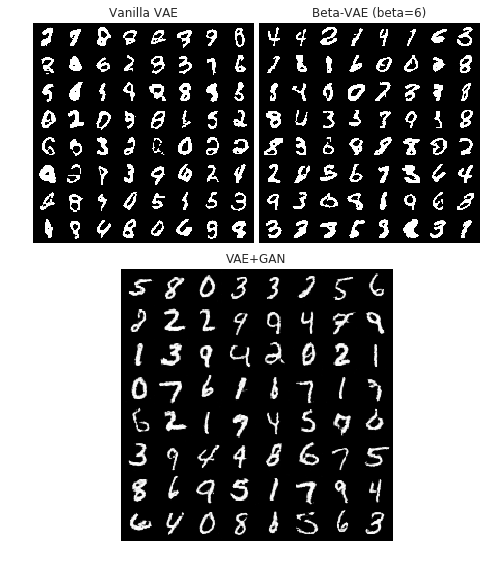

In [0]:
rows  = 2
columns = 3

fig_height = 5.
length_x_axis = 100
length_y_axis = 45
height = length_y_axis * rows
width = length_x_axis  * columns

plot_aspect_ratio= float(width)/float(height)

fig = plt.figure(figsize=(8,10))

gs = gridspec.GridSpec(2,2)
gs.update(wspace = 0.025, hspace = 0.0)
## Train 
ax1 = plt.subplot(gs[0, 0])
vae_tsne = "vae-final/vae_sample.png"
img=mpimg.imread(vae_tsne)
imgplot = plt.imshow(img)
plt.title("Vanilla VAE")
plt.axis("off")
ax2 = plt.subplot(gs[0, 1])
betavae_tsne = "vae-final/bvae_sample.png"
img=mpimg.imread(betavae_tsne)
imgplot = plt.imshow(img)
plt.title("Beta-VAE (beta=6)")
plt.axis("off")
ax3 = plt.subplot(gs[1, :])
vae_gan_tsne = "vae-final/vae_gan_sample.png"
img=mpimg.imread(vae_gan_tsne)
imgplot = plt.imshow(img)
plt.title("VAE+GAN")
plt.axis("off")
plt.savefig("vae-final/sample_results.png")

## Latent Tranversal

In [0]:
testpoint1, testpointlabel1 = train_loader.dataset[0]
testpoint2, testpoint2label2 = train_loader.dataset[1]
testpoint3, testpoint3label3 = train_loader.dataset[2]

print(testpointlabel1, testpoint2label2, testpoint3label3)

5 0 4


In [0]:
filename = 'vae-final/vae_traversal_testpoint_5.png'
traverse_latents(vae_model, testpoint1, Params.nb_latents, filename)
filename = 'vae-final/beta_vae_traversal_testpoint_5.png'
traverse_latents(beta_vae, testpoint1, Params.nb_latents, filename)

In [0]:
filename = 'vae-final/vae_gan_traversal_testpoint_5.png'
traverse_latents(G, testpoint1, Params.nb_latents, filename)

In [0]:
def display_three_plots(filename1, filename2, filename3,save_name):
     

     
    fig = plt.figure(figsize=(5,5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.025, hspace = 0.0)

    ## Train 
    ax1 = plt.subplot(gs[0, 0])
    vae_tsne =  filename1
    img=mpimg.imread(vae_tsne)
    imgplot = plt.imshow(img)
    plt.title("Vanilla VAE")
    plt.axis("off")
    ax2 = plt.subplot(gs[0, 1])
    betavae_tsne = filename2
    img=mpimg.imread(betavae_tsne)
    imgplot = plt.imshow(img)
    plt.title("Beta-VAE (beta=6)")
    plt.axis("off")
    ax3 = plt.subplot(gs[1, :])
    vae_gan_tsne = filename3
    img=mpimg.imread(vae_gan_tsne)
    imgplot = plt.imshow(img)
    plt.title("VAE+GAN")
    plt.axis("off")
    plt.savefig("vae-final/"+save_name)

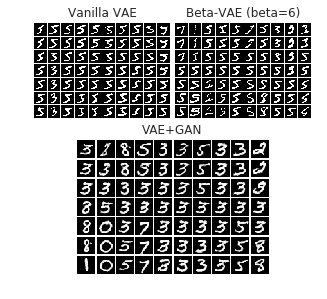

In [0]:
filename1 = 'vae-final/vae_traversal_testpoint_5.png'
filename2 = 'vae-final/beta_vae_traversal_testpoint_5.png'
filename3 = 'vae-final/vae_gan_traversal_testpoint_5.png'


display_three_plots(filename1,filename2,filename3,"traversal.png")

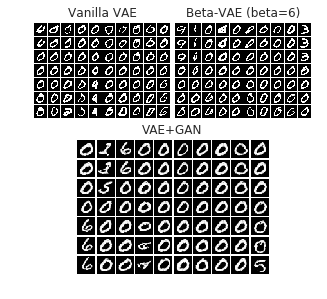

In [0]:
filename1 = 'vae-final/vae_traversal_testpoint_0.png'
traverse_latents(vae_model, testpoint2, Params.nb_latents, filename1)
filename2 = 'vae-final/beta_vae_traversal_testpoint_0.png'
#traverse_latents(beta_vae, testpoint2, Params.nb_latents, filename2)
filename3 = 'vae-final/vae_gan_traversal_testpoint_0.png'
traverse_latents(G, testpoint2, Params.nb_latents, filename3)
display_three_plots(filename1, filename2,filename3,"traversal0.png")

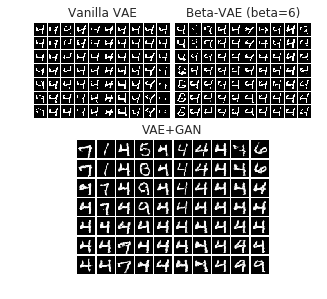

In [0]:
filename1 = 'vae-final/vae_traversal_testpoint_4.png'
traverse_latents(vae_model, testpoint3, Params.nb_latents, filename1)
filename2 = 'vae-final/beta_vae_traversal_testpoint_4.png'
#traverse_latents(beta_vae, testpoint3, Params.nb_latents, filename2)
filename3 = 'vae-final/vae_gan_traversal_testpoint_4.png'
traverse_latents(G, testpoint3, Params.nb_latents, filename3)
display_three_plots(filename1, filename2,filename3,"traversal4.png")

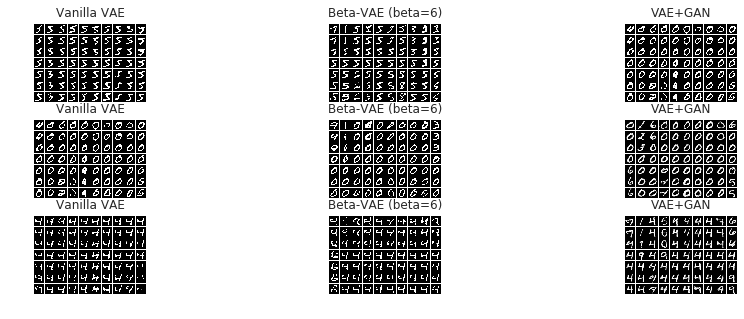

In [0]:
rows  = 3
columns = 3

fig_height = 5.
length_x_axis = 100
length_y_axis = 100
height = length_y_axis * rows
width = length_x_axis  * columns

plot_aspect_ratio= 3

fig = plt.figure(figsize=(fig_height  * plot_aspect_ratio, fig_height ))
gs = gridspec.GridSpec(rows,columns)

def add_subplot(row, col, filename,title):
    ## Train 
    ax1 = plt.subplot(gs[row, col])
    vae_tsne = filename
    img=mpimg.imread(vae_tsne)
    imgplot = plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    
    
filename1 = 'vae-final/vae_traversal_testpoint_5.png'
filename2 = 'vae-final/beta_vae_traversal_testpoint_5.png'
filename3 = 'vae-final/vae_gan_traversal_testpoint_5.png'

filename4 = 'vae-final/vae_traversal_testpoint_0.png'
filename5 = 'vae-final/beta_vae_traversal_testpoint_0.png'
filename6 = 'vae-final/vae_gan_traversal_testpoint_0.png'

filename7 = 'vae-final/vae_traversal_testpoint_4.png'
filename8 = 'vae-final/beta_vae_traversal_testpoint_4.png'
filename9 = 'vae-final/vae_gan_traversal_testpoint_4.png'

add_subplot(0,0,filename1, "Vanilla VAE")
add_subplot(0,1,filename2, "Beta-VAE (beta=6)")
add_subplot(0,2,filename3, "VAE+GAN")

add_subplot(1,0,filename4, "Vanilla VAE")
add_subplot(1,1,filename5, "Beta-VAE (beta=6)")
add_subplot(1,2,filename6, "VAE+GAN")

add_subplot(2,0,filename7, "Vanilla VAE")
add_subplot(2,1,filename8, "Beta-VAE (beta=6)")
add_subplot(2,2,filename9, "VAE+GAN")

plt.savefig("vae-final/all_traversal.png")

## Laplacian Variance

In [0]:
## Import CV
import cv2
import numpy


def laplacian_variance(images):
    return [cv2.Laplacian(image.numpy(), cv2.CV_32F).var() for image in images]


def laplacian_variance_numpy(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]

In [0]:
x_test, y_test = test_data[:2000], test_labels[:2000]
laplacian_variances = [laplacian_variance(x_test[y_test == i]) for i in range(10)]

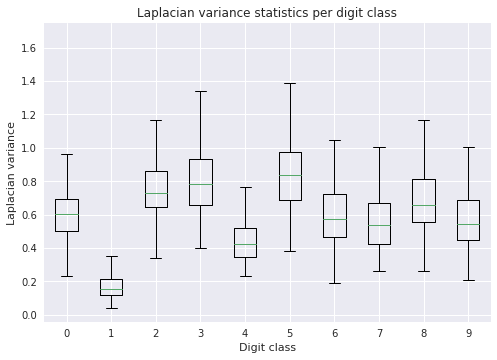

In [0]:
plt.boxplot(laplacian_variances, labels=range(10));
plt.xlabel('Digit class')
plt.ylabel('Laplacian variance')
plt.title('Laplacian variance statistics per digit class');

In [0]:
## Vanilla VAE
def plot_laplacian_variances(lvs_1, lvs_2, label2, title,path):
    plt.hist(lvs_1, bins=50, alpha=0.5 , label='Original images');
    plt.hist(lvs_2, bins=50, alpha= 0.5 , label=label2);
    plt.xlabel('Laplacian variance')
    plt.title(title)
    plt.legend()
    plt.savefig(path)

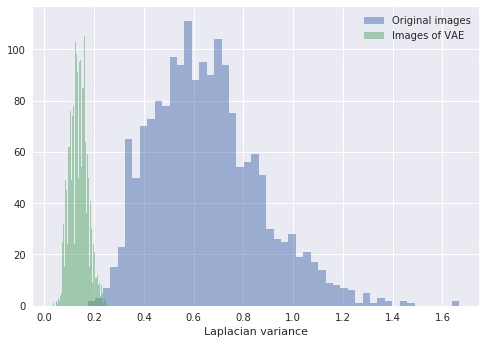

In [0]:
not_ones = y_test != 1
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
with torch.no_grad():
    vae_reconstructions = np.empty(shape=(len(x_test_not_ones),1,28,28))
    indx = 0
    for i, (x,y) in enumerate(zip(x_test_not_ones,y_test_not_ones)):
        if y != 1:
            recon_batch, mu, logvar = vae_model(x.unsqueeze(1).to(device))
            vae_reconstructions[indx]=(recon_batch.squeeze(0).detach().cpu())
            indx+=1
            
            
not_ones = y_test != 1
lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance_numpy(np.array(vae_reconstructions, dtype=np.uint8))
filename1 = "vae-final/vae_laplacian_variance_reconstructed.png"
plot_laplacian_variances(lvs_1, lvs_2, "Images of VAE", "", filename1)



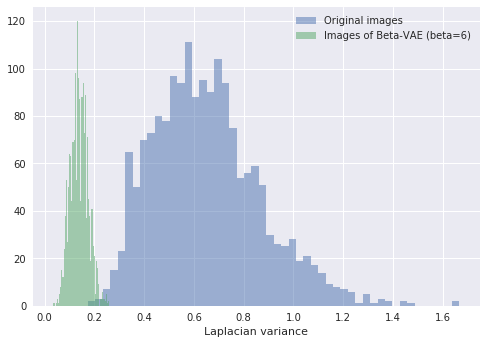

In [0]:
not_ones = y_test != 1
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
with torch.no_grad():
    bvae_reconstructions = np.empty(shape=(len(x_test_not_ones),1,28,28))
    indx = 0
    for i, (x,y) in enumerate(zip(x_test_not_ones,y_test_not_ones)):
        if y != 1:
            recon_batch, mu, logvar = beta_vae(x.unsqueeze(1).to(device))
            bvae_reconstructions[indx]
            =(recon_batch.squeeze(0).detach().cpu())
            indx+=1
            
            
not_ones = y_test != 1
lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance_numpy(
    np.array(bvae_reconstructions, dtype=np.uint8))
filename2 = "vae-final/bvae_laplacian_variance_reconstructed.png"
plot_laplacian_variances(lvs_1, lvs_2, 
        "Images of Beta-VAE (beta=6)", "", filename2)


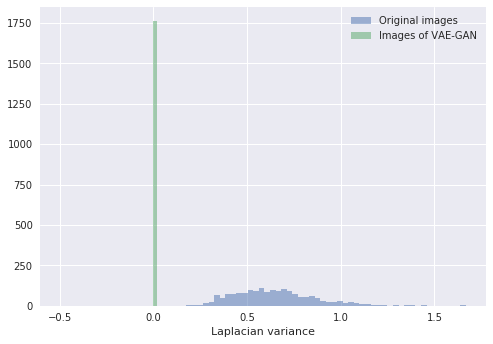

In [0]:
not_ones = y_test != 1
x_test_not_ones, y_test_not_ones = x_test[not_ones], y_test[not_ones]
with torch.no_grad():
    vae_gan_reconstructions = 
    np.empty(shape=(len(x_test_not_ones),1,28,28))
    indx = 0
    for i, (x,y) in enumerate(zip(x_test_not_ones,y_test_not_ones)):
        if y != 1:
            _, _, recon_batch = G(x.unsqueeze(1).to(device))
            vae_gan_reconstructions[indx]
            =(recon_batch.squeeze(0).detach().cpu())
            indx+=1
            
            
not_ones = y_test != 1
lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance_numpy(np.array(vae_gan_reconstructions, dtype=np.uint8))
filename3 = "vae-final/vae_gan_laplacian_variance_reconstructed.png"
plot_laplacian_variances(lvs_1, lvs_2, 
        "Images of VAE-GAN", "", filename3)


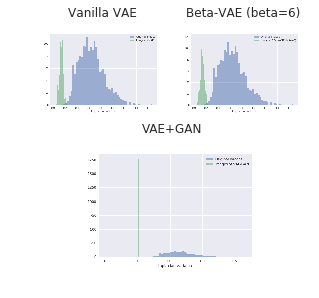

In [0]:
filename1 = "vae-final/vae_laplacian_variance_reconstructed.png"
filename2 = "vae-final/bvae_laplacian_variance_reconstructed.png"
filename3 = "vae-final/vae_gan_laplacian_variance_reconstructed.png"

display_three_plots(filename1, filename2,filename3,"laplacian_blur.png")

## Classifier

In [0]:
### Metrics - Base Class For all Metrics
class Metric:
  def __init__(self):
    pass
  def __call__(self, outputs, target, loss):
    raise NotImplementedError
    
  def reset(self):
    raise NotImplementedError
    
  def value(self):
    raise NotImplementedError
    
  def name(self):
    raise NotImplementedError
    
## Accuracy Metric
class AccumulatedAccuracyMetric(Metric):
  def __init__(self):
      self.correct = 0
      self.total = 0
      
  def __call__(self, outputs, target):
      # Track the accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (target == argmax.squeeze()).float().sum()
      self.correct += accuracy 
      self.total += target.size(0)
      return self.value()
  
  def reset(self):
      self.correct = 0
      self.total = 0

  def value(self):
      return 100 * float(self.correct) / self.total

  def name(self):
      return 'Accuracy'
    
    
## Loss
class RunningAverage ():
    """A simple class that maintains the 
    running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    
    ## Define NN
    self.fc1 = nn.Linear(10, 10)
    
    
  def forward(self,x):
    ## flat input features
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc1(x)
    
    return F.log_softmax(x, dim=1)  
  
  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *=s
    return num_features

In [0]:
## Training
from tqdm import trange

criterion = nn.CrossEntropyLoss()
classifier = Classifier()
if is_cuda:
  classifier = classifier.to(device)

# Loss and optimizer
learning_rate = 0.001
momemtum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 7,gamma = 0.1)
print(classifier)

Classifier(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
)


In [0]:
def train_classifier_epoch(model, epoch):
  model.train()
  metric = AccumulatedAccuracyMetric()
   
  for idx, (data, labels) in enumerate(train_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    if isinstance(model,ConvVAE):
        recon_batch, mu, logvar = model(data)
    else:
        mu, logvar,recon_batch = model(data)
        
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    classifier_loss.backward()
    optimizer.step()
    
    classifier_loss /= data.size(0)
     
    
    metric(outputs, labels)
    
  return 0.0, metric

## Test Epoch
"""
Test, classifier on learnt features
"""
def test_classifier_epoch(model,epoch):
  classifier.eval()
  metric = AccumulatedAccuracyMetric()
  
  for idx, (data, labels) in enumerate(test_loader):
    data= data.to(device)
    labels = labels.to(device)
    
    
    if isinstance(model,ConvVAE):
        recon_batch, mu, logvar = model(data)
    else:
        mu, logvar,recon_batch = model(data)
        
    ## classifier, pass latent vector
    outputs = classifier(mu)
    classifier_loss = criterion(outputs, labels)
    
    classifier_loss /= data.size(0)
    
    
    metric(outputs, labels)
    
    
  return 0.0, metric

In [0]:
## VAE - vanilla
vae_parameters  = list(vae_model.named_parameters())
for name, param in vae_parameters:
    param.requires_grad = False
    
beta_vae_parameters = list(beta_vae.named_parameters())
for name, param in vae_parameters:
    param.requires_grad = False
    
vae_gan_parameters = list(G.named_parameters())
for name, param in vae_gan_parameters:
    param.requires_grad = False


In [0]:
def train_and_test(model):
    
    train_accuracy = []
     
    test_accuracy = []
    n_epochs = 50
    for epoch in range(1, n_epochs):

      # Train stage
      train_loss, metric = train_classifier_epoch(model,epoch)
      
      train_accuracy.append(metric.value())

      message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'
            .format(epoch + 1, n_epochs,0.0)
      message += '\t Average Accuracy: \t{}: {}'
            .format(metric.name(), metric.value())
      print(message)

      val_loss, metrics = test_classifier_epoch(model,epoch)
       
      test_accuracy.append(metrics.value())

      message += '\nEpoch: {}/{}. Test set: Average loss: {:.4f}'
        .format(epoch + 1, n_epochs,   0.0)

      message += '\t Average Accuracy: \t{}: {}'
        .format(metrics.name(), metrics.value())


      print(message)
    
    return train_accuracy, test_accuracy

In [0]:
vae_train_ac, vae_test_ac =  train_and_test(vae_model)

Epoch: 2/50. Train set: Average loss: 0.0058	 Average Accuracy: 	Accuracy: 88.36333333333333
Epoch: 2/50. Train set: Average loss: 0.0058	 Average Accuracy: 	Accuracy: 88.36333333333333
Epoch: 2/50. Test set: Average loss: 0.0049	 Average Accuracy: 	Accuracy: 92.15
Epoch: 3/50. Train set: Average loss: 0.0038	 Average Accuracy: 	Accuracy: 92.3
Epoch: 3/50. Train set: Average loss: 0.0038	 Average Accuracy: 	Accuracy: 92.3
Epoch: 3/50. Test set: Average loss: 0.0034	 Average Accuracy: 	Accuracy: 93.66
Epoch: 4/50. Train set: Average loss: 0.0029	 Average Accuracy: 	Accuracy: 93.56333333333333
Epoch: 4/50. Train set: Average loss: 0.0029	 Average Accuracy: 	Accuracy: 93.56333333333333
Epoch: 4/50. Test set: Average loss: 0.0028	 Average Accuracy: 	Accuracy: 94.37
Epoch: 5/50. Train set: Average loss: 0.0024	 Average Accuracy: 	Accuracy: 94.21833333333333
Epoch: 5/50. Train set: Average loss: 0.0024	 Average Accuracy: 	Accuracy: 94.21833333333333
Epoch: 5/50. Test set: Average loss: 0.002

In [0]:
import pickle
def save_lists(l, pickle_filename):
    with open(pickle_filename, 'wb') as f:
        pickle.dump(l, f) 
def load_lists(l, picklet_filename):
    with open(pickle_filename,'rb') as f:
        l = pickle.load(f)
        

In [0]:
## save lists
save_lists(vae_train_ac,"vae-final/vae-train-classifier-acc.pkl")
save_lists(vae_test_ac,"vae-final/vae-test-classifier-acc.pkl")


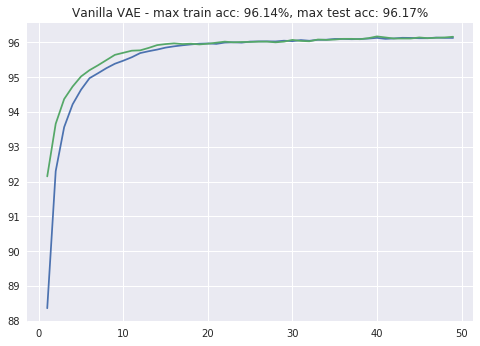

In [0]:
n_epochs = 50
plt.plot(range(1, n_epochs),vae_train_ac)
plt.plot(range(1,n_epochs),vae_test_ac)
plt.title("Vanilla VAE - max train acc: {}%, max test acc: {}%"
          .format(round(max(vae_train_ac),2),max(vae_test_ac)))
plt.savefig("vae-final/vae-train-test-acc-classifier.png")

In [0]:

bvae_train_ac, bvae_test_ac =  train_and_test(beta_vae)

Epoch: 2/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 91.915
Epoch: 2/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 91.915
Epoch: 2/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 92.68
Epoch: 3/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 92.73666666666666
Epoch: 3/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 92.73666666666666
Epoch: 3/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.26
Epoch: 4/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.18666666666667
Epoch: 4/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.18666666666667
Epoch: 4/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.6
Epoch: 5/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.475
Epoch: 5/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 93.475
Epoch: 5/50. Test set: Average loss: 0.0000	 Average Accuracy

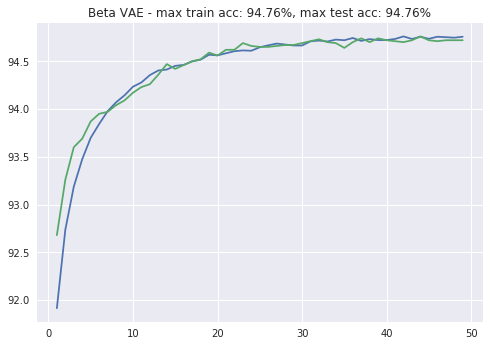

In [0]:
## save lists
save_lists(bvae_train_ac,"vae-final/bvae-train-classifier-acc.pkl")
save_lists(bvae_test_ac,"vae-final/bvae-test-classifier-acc.pkl")

n_epochs = 50
plt.plot(range(1, n_epochs),bvae_train_ac)
plt.plot(range(1,n_epochs),bvae_test_ac)
plt.title("Beta VAE - max train acc: {}%, max test acc: {}%"
          .format(round(max(bvae_train_ac),2),max(bvae_test_ac)))
plt.savefig("vae-final/bvae-train-test-acc-classifier.png")


In [0]:
vae_gan_train_ac, vae_gan_test_ac =  train_and_test(G)

Epoch: 2/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 26.76
Epoch: 2/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 26.76
Epoch: 2/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 33.57
Epoch: 3/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 39.71
Epoch: 3/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 39.71
Epoch: 3/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 47.65
Epoch: 4/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 53.275
Epoch: 4/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 53.275
Epoch: 4/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 61.43
Epoch: 5/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 65.35833333333333
Epoch: 5/50. Train set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 65.35833333333333
Epoch: 5/50. Test set: Average loss: 0.0000	 Average Accuracy: 	Accuracy: 72.0
Epoch: 

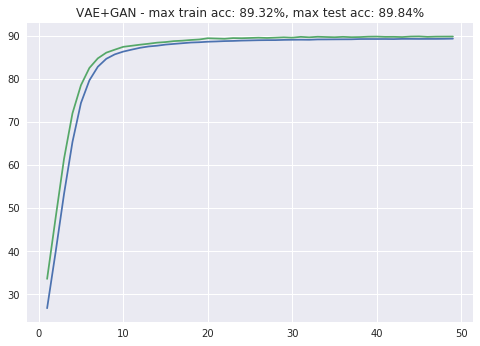

In [0]:
## save lists
save_lists(vae_gan_train_ac,"vae-final/vaeg-train-classifier-acc.pkl")
save_lists(vae_gan_test_ac,"vae-final/vaeg-test-classifier-acc.pkl")

n_epochs = 50
plt.plot(range(1, n_epochs),vae_gan_train_ac)
plt.plot(range(1,n_epochs),vae_gan_test_ac)
plt.title("VAE+GAN - max train acc: {}%, max test acc: {}%"
          .format(round(max(vae_gan_train_ac),2),max(vae_gan_test_ac)))
plt.savefig("vae-final/vae_gan-train-test-acc-classifier.png")

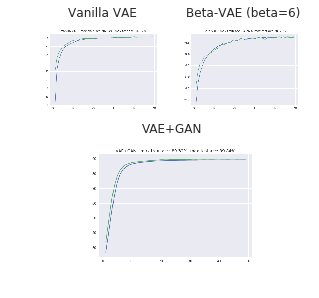

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
filename1 = "vae-final/vae-train-test-acc-classifier.png"
filename2 = "vae-final/bvae-train-test-acc-classifier.png"
filename3 = "vae-final/vae_gan-train-test-acc-classifier.png"

display_three_plots(filename1, filename2,filename3,"classifier.png")


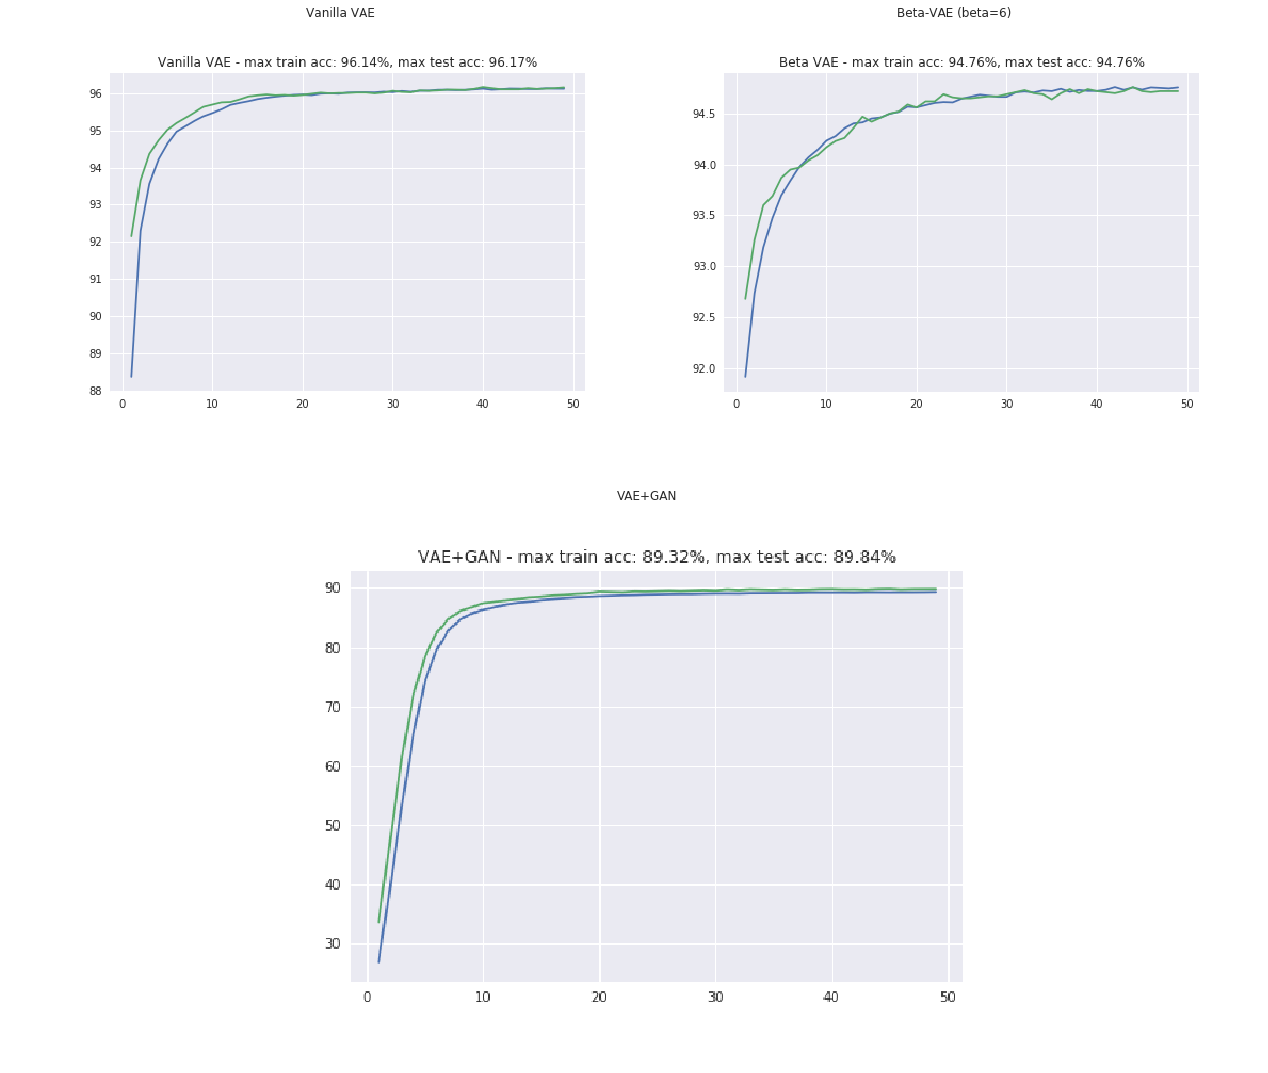

In [0]:
fig = plt.figure(figsize = (22,20))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0.0, hspace=0.0)
plt.grid(b=None)
## Train 
ax1 = plt.subplot(gs[0, 0])
vae_tsne = filename1
img=mpimg.imread(vae_tsne)
imgplot = plt.imshow(img)
plt.title("Vanilla VAE")
plt.axis("off")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs[0, 1])
betavae_tsne = filename2
img=mpimg.imread(betavae_tsne)
imgplot = plt.imshow(img)
plt.title("Beta-VAE (beta=6)")
plt.axis("off")
ax2.set_aspect('equal')
ax3 = plt.subplot(gs[1,:])
vae_gan_tsne =filename3
img=mpimg.imread(vae_gan_tsne)
imgplot = plt.imshow(img)
ax3.set_aspect('equal')
plt.title("VAE+GAN")
plt.axis("off")
plt.savefig("vae-final/classifier.png")

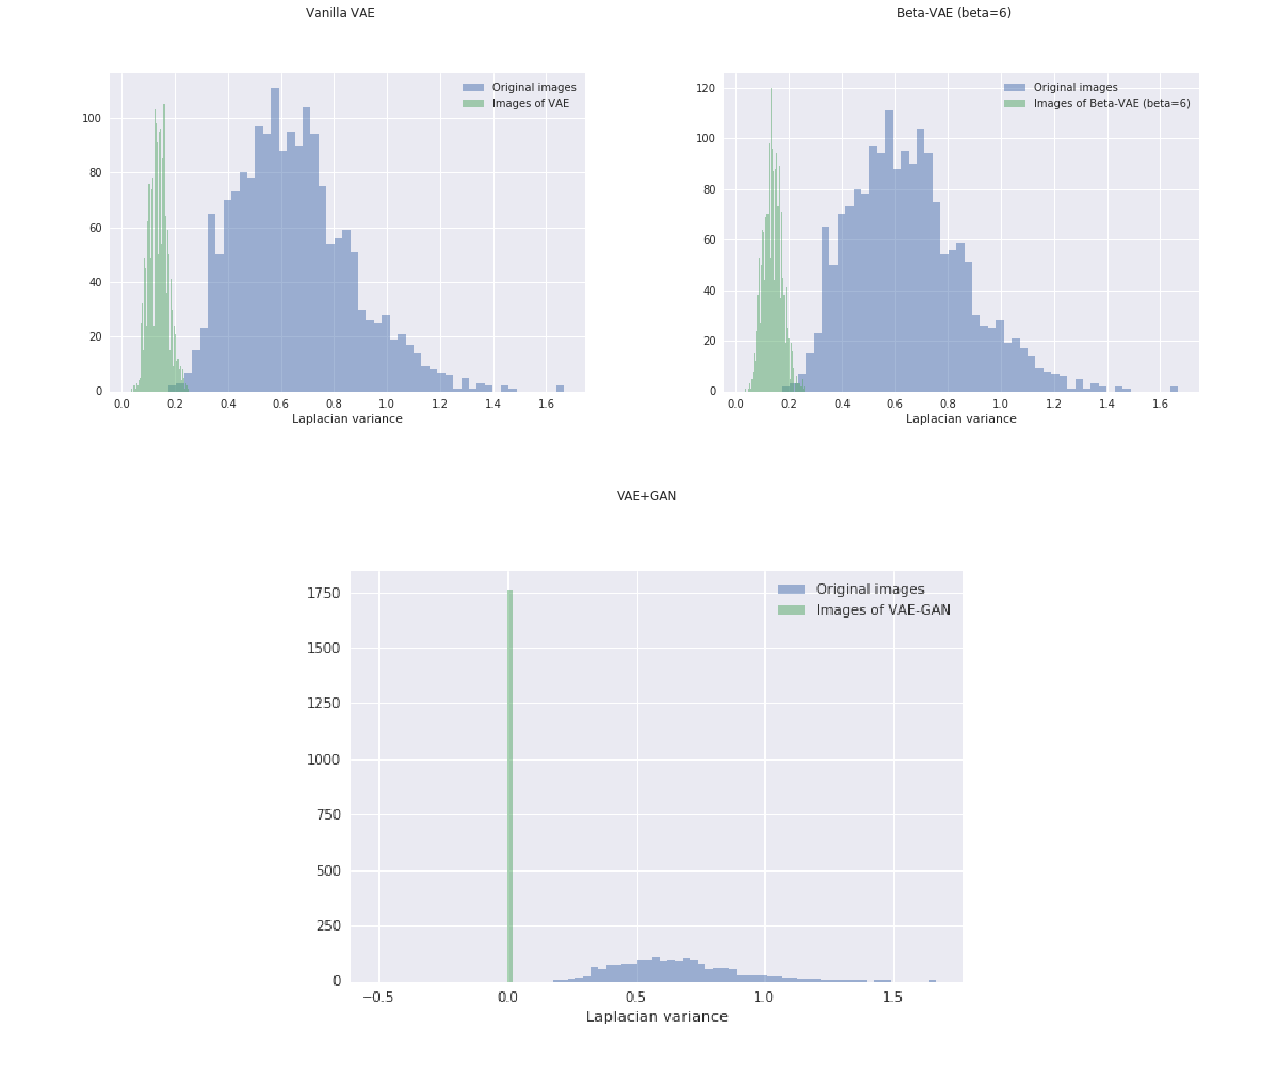

In [0]:
fig = plt.figure(figsize = (22,20))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0.0, hspace=0.0)
plt.grid(b=None)
## Train 
ax1 = plt.subplot(gs[0, 0])
vae_tsne = filename1
img=mpimg.imread(vae_tsne)
imgplot = plt.imshow(img)
plt.title("Vanilla VAE")
plt.axis("off")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs[0, 1])
betavae_tsne = filename2
img=mpimg.imread(betavae_tsne)
imgplot = plt.imshow(img)
plt.title("Beta-VAE (beta=6)")
plt.axis("off")
ax2.set_aspect('equal')
ax3 = plt.subplot(gs[1,:])
vae_gan_tsne =filename3
img=mpimg.imread(vae_gan_tsne)
imgplot = plt.imshow(img)
ax3.set_aspect('equal')
plt.title("VAE+GAN")
plt.axis("off")
plt.savefig("vae-final/laplacian_blur.png")